# Fundamental Matrix

In [ ]:
import math
import os
import sys

sys.path.insert(0, os.path.abspath('/data/autocnet'))

import autocnet
from autocnet import CandidateGraph

# The GPU based extraction library that contains SIFT extraction and matching
import cudasift as cs

# A method to resize the images on the fly.
from scipy.misc import imresize

%pylab inline
figsize(16,4)

## CandidateGraph -> Custom Extraction Func -> Matching

In [ ]:
a = 'AS15-P-0111_CENTER_LRG_CROPPED.png'
b = 'AS15-P-0112_CENTER_LRG_CROPPED.png'

adj = {a:[b],
       b:[a]}

cg = CandidateGraph.from_adjacency(adj)

# Enable the GPU
autocnet.cuda(enable=True, gpu=0)

# Write a custom keypoint extraction function - this could get monkey patched onto the graph object...
def extract(arr, downsample_amount=None, **kwargs):
    total_size = arr.shape[0] * arr.shape[1]
    if not downsample_amount:
        downsample_amount = math.ceil(total_size / 12500**2)
    shape = (int(arr.shape[0] / downsample_amount), int(arr.shape[1] / downsample_amount))
    # Downsample
    arr = imresize(arr, shape, interp='lanczos')
    
    npts = max(arr0.shape) / 3.5
    sd = cs.PySiftData(npts)
    cs.ExtractKeypoints(arr, sd, **kwargs)
    kp, des = sd.to_data_frame()
    kp = kp[['x', 'y', 'scale', 'sharpness', 'edgeness', 'orientation', 'score', 'ambiguity']]
    kp['score'] = 0.0
    kp['ambiguity'] = 0.0
    
    return kp, des, sd, downsample_amount, arr

arr0 = cg.node[0].geodata.read_array()
kp0, des0, sd0, downsample_amount0, arr0 = extract(arr0, thresh=1)

arr1 = cg.node[1].geodata.read_array()
kp1, des1, sd1, downsample_amount1, arr1 = extract(arr1, thresh=1)


In [ ]:
# Use the query capability to reduce the number of correspondences
sd0 = cs.PySiftData.from_data_frame(kp0, des0)
sd1 = cs.PySiftData.from_data_frame(kp1, des1)
# Apply the matcher
cs.PyMatchSiftData(sd0, sd1)

matches, _ = sd0.to_data_frame()
submatches = matches.query('ambiguity <= 0.95 and score >= 0.925310')

## Fundamental Matrix
The fundamental matrix describes the relationship between a point correspondence in one image and an associated epipolar line in another image.  Computation of a fundamental matrix is a key outlier detection method as it provides the change to apply RANSAC or MLE outlier detection methods and offers a quantifiable error metric for correspondences. 

![F](http://www.consortium.ri.cmu.edu/data/MultiView/epipolar.JPG)

In [5]:
# Fundamental Matrix
from autocnet.transformation import fundamental_matrix as fm

kp1 = submatches[['x','y']]
kp2 = submatches[['match_xpos', 'match_ypos']]

# Computation returns both the F matrix and a boolean mask indicating whether or not the correspondence is an outlier.
F, mask = fm.compute_fundamental_matrix(kp1, kp2, method='ransac', reproj_threshold=2.0)
F = fm.enforce_singularity_constraint(F)

In [6]:
# The fundamental matric is a 3x3 transformation matrix.
F

array([[ -4.44688386e-09,  -2.74952864e-09,   1.73428165e-03],
       [  6.58309462e-09,  -8.21632602e-10,  -6.77163910e-04],
       [ -1.68369003e-03,   6.55776150e-04,   1.00000000e+00]])

## Visualization of reprojective error
Here we generate histograms of the reprojective error for inliners and outliers as one method to check both the quality of the F-matrix and the quality of the correspondences.

The inliers look pretty good here with error right around 0.  Outliers by in large look okay, with reprojection error centered around 1 pixel.  The tails of the distirbution are concerning though...

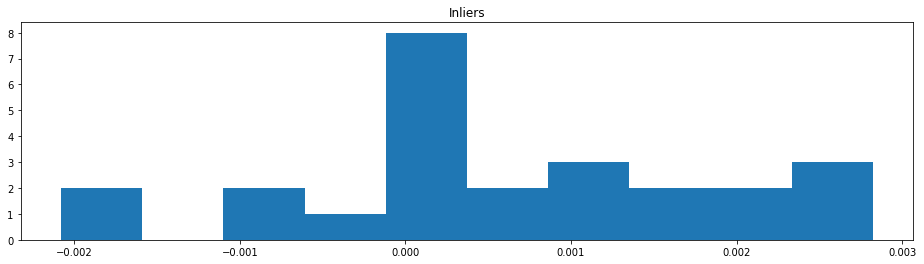

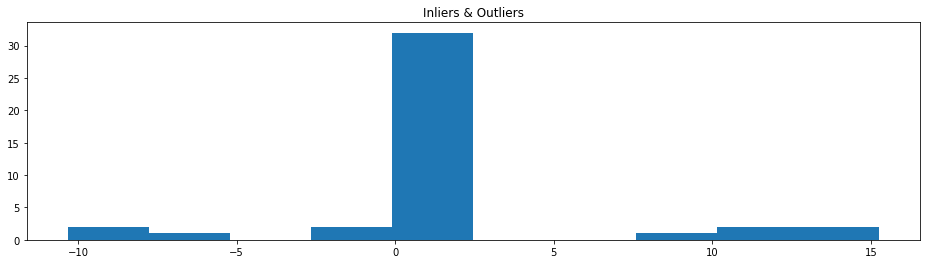

In [8]:
unmasked_err = fm.compute_fundamental_error(F, kp1, kp2)
masked_err = fm.compute_fundamental_error(F, kp1[mask], kp2[mask])
hist(masked_err)
title('Inliers')
show()
hist(unmasked_err)
title('Inliers & Outliers')

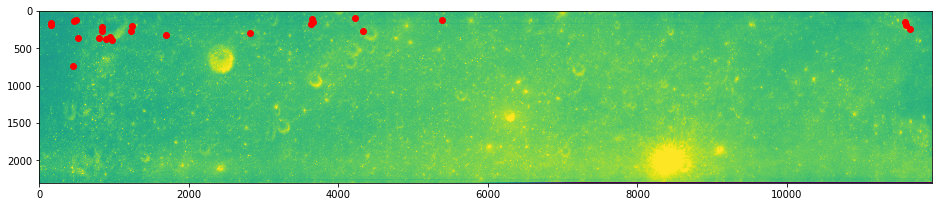

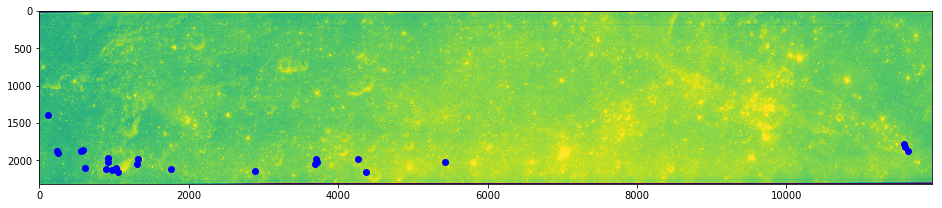

In [9]:
# Inliers
imshow(arr0)
plot(kp1[mask].x, kp1[mask].y, 'ro')
show()
imshow(arr1)
plot(kp2[mask].match_xpos, kp2[mask].match_ypos, 'bo')

## Initial Conclusion
For a first cut, with no apriori information, we have a number of good correspondences to support further matching.  If these results look 'good enough' it might make sense to try generating a control network.  Alternatively, it might make sense to apply further processing to try and push back towards a native resolution.